# Data Science Midterm Project

## Introduction

A tip is an additional amount of money given to a person that is providing a service. It's a addition to the service fee that is charged. This amount is mostly seem as a signal of gratitude and a custom in many countries.
In some places around the world is common to tip the waiter in restaurants and cafeterias after finishing a meal. The amount of the tip can be related with the customer's check, a percentage ranging from 10%-30%. This amount is in some cases a important part of the waiter income.
 In some places tipping is an informal action based on local custom, in other countries there are laws governing how tips are given. For example, in many places it's ilegal to tip government workers and more widely police officers, what can be considered bribery.
 There are 5 motivations for tipping accordly with Michael Lynn [3]:
- Showing off
- To supplement the server's income and make them happy
- For improved future service
- To avoid disapproval from the server
- A sense of duty

Problems also arise from the practice of tipping. Some people are uncomfortable having to determine the value of a tip leading to social anxiety. In other cases, discrimination can lead to unfair differences in value, particularly in countries where tips are an important part of compensation.

## Dataset

The data used in this project was collected from Kaggle [2].
It's part of a collection of case studies for business statitics [1] and it's also included in Seaborn package.
This data was recorded by a single waiter in the same restaurant over a period of few months [2].
As it is the data of a single waiter, the data collected refer exclusively to the restaurant's customers and their characteristics.
The dataset contains 244 rows and 7 columns. In this study the dependent variable is the column "tip".

### Columns and data types
- total_bill: Bill in dollars (float number)
- tip: Tip in dollars (float number)
- sex: Sex of the bill payer ("Male" or "Female")
- smoker: whether there were smokers in the party ("Yes" or "No")
- day: day of the week (string)
- time: time of the day ("Dinner" or "Lunch")
- size: size of the party (integer number)


## Objective

The objective of this work is to find out which factors contribute the most to higher tips.
We will use inference tools to evaluate the correlation between the independent variables and also the correlations with the dependent variable ("tip"). With this we will be able to draw a profile of a client or a group of clients that favor the increase or reduction of the value of the tips.
We also want to use this data to be able to quantitatively predict the value of a tip based on the independent variables.
For the prediction, we will try to find the best regression model for our problem by evaluating the model error on the training data and, most importantly, in the test data.
We will test the prediction success of some popular regression models and assess which best represents our problem. Next, we will try to optimize the model's hyperparameters.

## Dataset Table

In [231]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import numpy as np
from yellowbrick.features import Rank2D, Rank1D
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn import svm
from yellowbrick.regressor import ResidualsPlot

df = pd.read_csv('data/tips.csv')
df

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


## Statistical Summary



In [232]:
stats = df.describe()
stats

,total_bill,tip,size
count,244.000000,244.000000,244.000000
mean,19.785943,2.998279,2.569672
std,8.902412,1.383638,0.951100
min,3.070000,1.000000,1.000000
25%,13.347500,2.000000,2.000000
50%,17.795000,2.900000,2.000000
75%,24.127500,3.562500,3.000000
max,50.810000,10.000000,6.000000


## Density histogram
Below we have the density histogram from the 3 numerical variables present in our dataset.

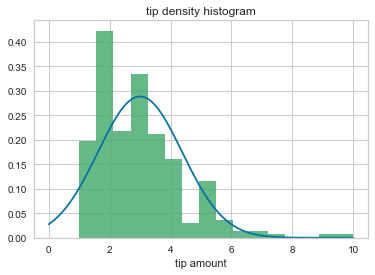

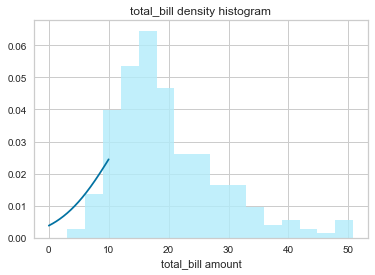

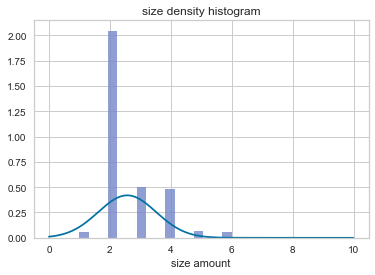

In [233]:
import matplotlib.pyplot as plt
from scipy.stats import norm

for variable in ['tip', 'total_bill', 'size']:
    plt.hist(df[variable], density=True, bins=16, alpha=0.8, color=np.random.rand(3,))
    x_axis = np.arange(0, 10, 0.01)
    plt.plot(x_axis, norm.pdf(x_axis, stats[variable]["mean"], stats[variable]["std"]))
    plt.title(variable + " density histogram")
    plt.xlabel(variable + " amount")
    plt.show()

## Preprocessing

In order to train a model, we need to convert the columns into numerical values. The "total_bill", "tip" and "size" columns are already numeric but the others need to be converted, so they can contribute to the model. The "sex", "smoker" and "time" columns have only 2 different values, so we can represent the different values by 0 and 1. However, the "day" column has 4 different possibilities, from Thursday to Sunday. So in this case I'm using one hot encoding to create 4 new columns that contain the value 1 if the data point has the corresponding day of the week

In [235]:
# Separating the target column from the rest of the columns
target_column = "tip"
y = df[target_column]
X = df.drop(target_column, axis=1, inplace=False)

descriptions = X.columns

# Converting to binary values (0, 1)
X["smoker"] = [ 1 if x == "Yes" else 0 for x in X["smoker"] ]
X["time"] = [ 1 if x == "Dinner" else 0 for x in X["time"] ]
X["sex"] = [ 1 if x == "Male" else 0 for x in X["sex"] ]

# One-hot encoding
days = pd.get_dummies(X["day"])
X = X.drop("day", axis=1)
X = pd.concat([X, days], axis=1)
print("** Dataframe after the pre processing **")
X

** Dataframe after the pre processing **


,total_bill,sex,smoker,time,size,Fri,Sat,Sun,Thur
0,16.99,0,0,1,2,0,0,1,0
1,10.34,1,0,1,3,0,0,1,0
2,21.01,1,0,1,3,0,0,1,0
3,23.68,1,0,1,2,0,0,1,0
4,24.59,0,0,1,4,0,0,1,0
...,...,...,...,...,...,...,...,...,...
239,29.03,1,0,1,3,0,1,0,0
240,27.18,0,1,1,2,0,1,0,0
241,22.67,1,1,1,2,0,1,0,0
242,17.82,1,0,1,2,0,1,0,0


## Correlation between variables

A way to better understand the data is by calculating the correlation between the variables. This can give us interesting insights and also indicate columns that could be removed when we train the model. Independent variables with high correlation with each other can indicate a dependency between them, giving us the opportunity to remove one of them and test the model's accuracy.

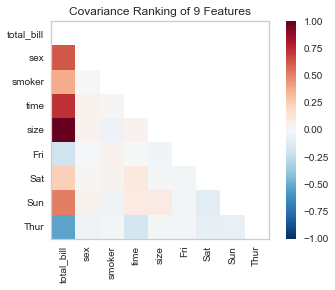

<AxesSubplot:title={'center':'Covariance Ranking of 9 Features'}>

In [236]:
# Instantiate the visualizer with the Pearson ranking algorithm
visualizer = Rank2D(algorithm='covariance', features=X.columns, target_column = "tip")

visualizer.fit(X, y)           # Fit the data to the visualizer
visualizer.transform(X)        # Transform the data
visualizer.show()

The "size" and "time" variables have the strongest correlation with "total_bill".

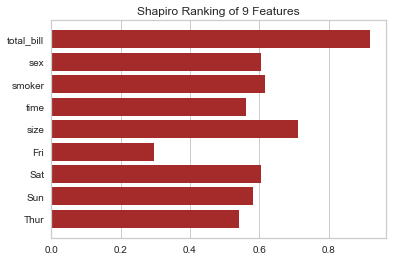

<AxesSubplot:title={'center':'Shapiro Ranking of 9 Features'}>

In [237]:
visualizer1d = Rank1D(color="brown")
visualizer1d.fit(X, y)
visualizer1d.transform(X)
visualizer1d.show()

The variables "total_bill" and "size" have the strongest correlation with "tip".


## Relation between Total Bill, Party Size and Tip

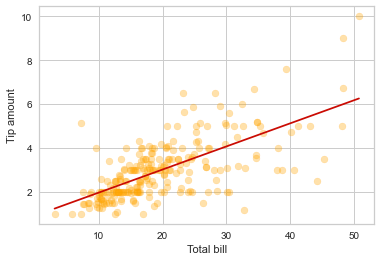

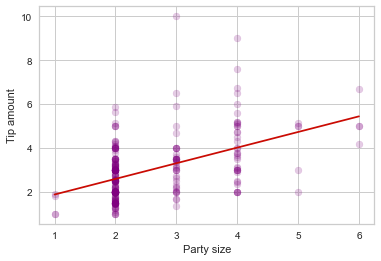

In [253]:
from scipy import stats

def plot_lin_reg(x):
    gradient, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    mn=np.min(x)
    mx=np.max(x)
    x1=np.linspace(mn,mx,500)
    y1=gradient*x1+intercept
    plt.plot(x1,y1,'-r')

plot_lin_reg(X["total_bill"])
plt.scatter(X["total_bill"], y, alpha=0.33, c="orange")
plt.xlabel("Total bill")
plt.ylabel("Tip amount")
plt.show()

plot_lin_reg(X["size"])
plt.scatter(X["size"], y, alpha=0.2, c="purple")
plt.xlabel("Party size")
plt.ylabel("Tip amount")
plt.show()


## Spliting data into train and test data

In [239]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print("Train data size: " + str(X_train.shape[0]) + ", Test data size: " + str(X_test.shape[0]))

Train data size: 163, Test data size: 81


## Machine Learning

### Choosing the correct model

Our target variable is a scalar number, not a category. For this reason we know we need a regression model. Below I will test the R2 score for different models in order to determine which one represents our problem most significantly.

### Testing four different regression models

In [240]:
# models to be evaluated
models = []
models.append(("LinearRegression", LinearRegression()))
models.append(("ElasticNet", ElasticNet(alpha=0.001)))
models.append(("RandomForest", RandomForestRegressor(max_depth=2, random_state=0)))
models.append(("SVM", svm.SVR()))

def print_cross_val_results(models, X, y):
    results = []
    for name, model in models:
        score = cross_val_score(model, X, y, scoring="r2").mean()
        results.append((name, score))

    return pd.DataFrame([r[1] for r in results], index=[r[0] for r in results], columns=["R2 Score on cross validation"])

print_cross_val_results(models, X_train, y_train)

,R2 Score on cross validation
LinearRegression,0.402699
ElasticNet,0.403422
RandomForest,0.442471
SVM,0.338703


### Tuning hyper-parameters

The Random Forest model obtained the best score. But we still have to choose which hyper parameters could give us a better result. For that I will run the R2 score calculate for different parameters of Random Forest Regressor.

In [241]:

models = []
# creating 4 different random forest models each one with a different depth value
for i in range(2, 6):
    models.append(("RandomForest max_depth=" + str(i), RandomForestRegressor(max_depth=i, random_state=0)))

print_cross_val_results(models, X_train, y_train)

,R2 Score on cross validation
RandomForest max_depth=2,0.442471
RandomForest max_depth=3,0.463845
RandomForest max_depth=4,0.449696
RandomForest max_depth=5,0.436304


**The best result we had for the max_depth hyper-parameter was 3, with an R2 score of 0.46.**
.
### Training the model

In [242]:
model = RandomForestRegressor(max_depth=3, random_state=0)
model.fit(X_train, y_train)
print("R2 score on train data: " + "{:.2f}".format(model.score(X_train, y_train)) + "%")

R2 score on train data: 0.65%


In [243]:
from sklearn.metrics import r2_score

y_pred = model.predict(X_test)
print("R2 score on test data: " + "{:.2f}".format(r2_score(y_test, y_pred)) + "%")

R2 score on test data: 0.31%


In [244]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
print("MAE score on test data: " + "{:.2f}".format(mean_absolute_error(y_test, y_pred)))
print("MAPE score on test data: " + "{:.2f}".format(mean_absolute_percentage_error(y_test, y_pred)) + "%")

MAE score on test data: 0.71
MAPE score on test data: 0.29%


### Evaluating residuals

C:\Users\bruno\Code\bsc\data-science-midterm\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


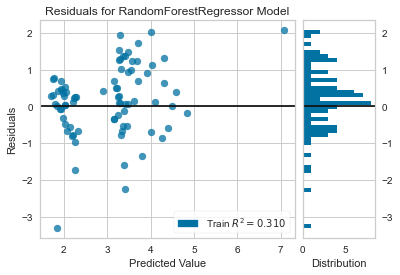

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [245]:
visualizer_residuals = ResidualsPlot(model)
visualizer_residuals.fit(X_test, y_test)
visualizer_residuals.show()

### Feature importance

In [246]:
pd.DataFrame(model.feature_importances_, index=X.columns).sort_values(0, ascending=False)

,0
total_bill,0.859626
size,0.094183
smoker,0.024162
Sat,0.008831
sex,0.005878
Fri,0.002210
time,0.002174
Sun,0.002149
Thur,0.000787


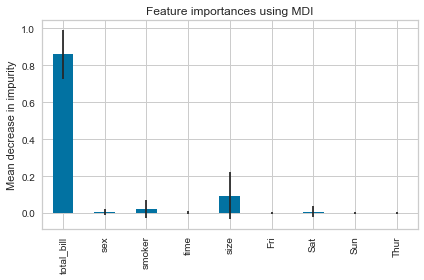

In [247]:
fig, ax = plt.subplots()
forest_importances = pd.Series(model.feature_importances_, index=X.columns)
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Conclusions

### Results of the ML model

The final regression model gave us a R2 score of 0.31% when evaluated against the test data. Because it's in between the 0-1 range we conclude that this model is better than a horizontal hyperplane defined by the mean values.
The MAE of 0.71 indicates that the average error of the model predictions is equal to 0.71 which is acceptable as the tip mean is equal to 3. Also, by looking the feature importance values we extracted from the model, we see that having the total_bill and the size columns as the most important variables fits the common sense.
By analysing the residuals graph, we have the residuals' distribution with most of the mass around 0 which validates that our model is appropriate to represent the data.

### Project evaluation and results

The first step of the project was to understand the data we have at hand. Using statistical functions like the mean and standard deviation, we could understand the quantities we are dealing with. The "tip" density histogram served as an additional step in this understanding so that we could evaluate how the dependent variable "tip" behaves within the samples we are using.
Then we use preprocessing methods to transform category variables into numerical values so we could use more quantitative tools at our disposal and have more data to train the Machine Learning model.
We also analyzed how each variable relates to each other using the covariance algorithm. This analysis aims to identify whether we have independent variables that are actually dependent on each other and could negatively impact the training of the model. We could also get a sense of which variables are most strongly correlated with "tip" and check later in the final model if these variables really contribute the most, or we made some mistake along the way.
Because we have means of objectively evaluating the outcome of models, we were able to test different models and compare the error. Even more, we could evaluate hyperparameters like "depth" in the random forest model in order to obtain the model parameters that could give us the best results in our dataset.
Finally, we analysed the feature importance coeficients to understand what variable contributes most to change the tip.

### Further study

A second step in this study could use a dataset that contains data from multiple waiters with additional information such as waiter's gender, race, age. In this way, we could infer whether discriminating factors could collaborate to increase or decrease tips.



## Reference
- [1] Bryant, P. G. and Smith, M (1995) Practical Data Analysis: Case Studies in Business Statistics. Homewood, IL: Richard D. Irwin Publishing
- [2] Amini, Z. (2021, August 26). Tips Dataset. Kaggle. Retrieved June 11, 2022, from https://www.kaggle.com/datasets/aminizahra/tips-dataset
- [3] Saltzman, M., &amp; Melker, S. de. (2016, March 26). Why do we tip? PBS. Retrieved June 11, 2022, from https://www.pbs.org/newshour/economy/why-do-we-tip